### Anna Landi (aol4h), Beza Delelegn (bmd5bc), and Aparna Marathe (am7ad)
Note: collaborated with other NFL project team (Arjun Ganesh (avg3xt), Nick Landi (nyl4gw), Elizabeth Lee (ewl3dv), and Anahita Sharma (ahs3zq)) on data annotation and preprocessing steps.

## Install Packages/Dependencies:

In [ ]:
!pip install labelbox

In [ ]:
# YOLOv5 packages/dependencies
import torch
import cv2
from google.colab.patches import cv2_imshow 
from PIL import Image

# model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-5-5 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow import keras
from labelbox import Client, Label
from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd '/content/gdrive/MyDrive/DS6050_project'

/content/gdrive/.shortcut-targets-by-id/1Ovczq4RB55XmRgRsS4bOdoyPS1LLF0GX/DS6050_project


## Load Data:

In [ ]:
# data from Labelbox in JSON format
data = pd.read_json('deeplearning_merged_data.json')

In [ ]:
# check that data loaded in correctly
data.head()

,ID,DataRow ID,Labeled Data,Label,Created By,...,Dataset Name,Reviews,View Label,Has Open Issues,Skipped
0,cl20wxeak0o0x0z8fde1p0hg3,cl20wu59000150zt17dal0q13,https://storage.labelbox.com/cl20wdn770n3f0z9r...,{'objects': [{'featureId': 'cl20wxijf00013f6ch...,am7ad@virginia.edu,...,nfl_data_new,[],https://editor.labelbox.com?project=cl20wjm6s0...,0,False
1,cl216zb6907rh0za21j096hyg,cl20wu59000190zt1a0213v9m,https://storage.labelbox.com/cl20wdn770n3f0z9r...,{'objects': [{'featureId': 'cl216zfx900013f6cg...,am7ad@virginia.edu,...,nfl_data_new,[],https://editor.labelbox.com?project=cl20wjm6s0...,0,False
2,cl216zbey0a8910as2ed642gd,cl20wu590001d0zt128nm9ciw,https://storage.labelbox.com/cl20wdn770n3f0z9r...,{'objects': [{'featureId': 'cl21733b0001k3f6cm...,am7ad@virginia.edu,...,nfl_data_new,[],https://editor.labelbox.com?project=cl20wjm6s0...,0,False
3,cl2172o300aal10as1ays7c0d,cl20wu591001h0zt1163j9is9,https://storage.labelbox.com/cl20wdn770n3f0z9r...,{'objects': [{'featureId': 'cl2175idg002q3f6cp...,am7ad@virginia.edu,...,nfl_data_new,[],https://editor.labelbox.com?project=cl20wjm6s0...,0,False
4,cl21759n408220z9e0j0far2k,cl20wu591001l0zt1h7ijcsbq,https://storage.labelbox.com/cl20wdn770n3f0z9r...,{'objects': [{'featureId': 'cl21777c800423f6c9...,am7ad@virginia.edu,...,nfl_data_new,[],https://editor.labelbox.com?project=cl20wjm6s0...,0,False


In [ ]:
# number of images before dropping unlabeled images
data.shape

(1050, 18)

In [ ]:
# drop unlabeled images
data = data[data.Skipped == False].reset_index(drop = True)

In [ ]:
# number of images after dropping unlabeled images
data.shape

(1038, 18)

## Data Preprocessing:

In [ ]:
# extract the following information: classification (toe or heel), x-coordinate, y-coordinate, and corresponding image ID
value_list = []
x_list = []
y_list = []
externalid_list = []

for j in range(0, len(data['External ID'])):
  current_id = data['External ID'][j]
  for i in range(0, len(data['Label'][j]['objects'])):
    x_list.append(data['Label'][j]['objects'][i]['point']['x'])
    y_list.append(data['Label'][j]['objects'][i]['point']['y'])
    externalid_list.append(current_id)
    value_list.append(data['Label'][j]['objects'][i]['value'])

In [ ]:
# save as pandas dataframe for subsequent analyses
df = pd.DataFrame({'values': value_list,
                   'x': x_list,
                   'y': y_list,
                   'external_id': externalid_list})

In [ ]:
# visually assess dataframe
df.head()

,values,x,y,external_id
0,toes,530.503,517.621,57507_000161_Sideline_frame552.jpg
1,toes,627.704,529.332,57507_000161_Sideline_frame552.jpg
2,toes,256.468,478.975,57507_000161_Sideline_frame552.jpg
3,toes,230.704,448.527,57507_000161_Sideline_frame552.jpg
4,toes,16.395,377.091,57507_000161_Sideline_frame552.jpg


In [ ]:
# total number of manually annotated heels and toes
df['values'].value_counts()

heels    16710
toes     16198
Name: values, dtype: int64

In [ ]:
IMG_DIR = '/content/gdrive/MyDrive/DS6050_project/dataset'

In [ ]:
# example of extracted player information for one photo 
df[df['external_id'] == '57507_000161_Sideline_frame552.jpg']

,values,x,y,external_id
0,toes,530.503,517.621,57507_000161_Sideline_frame552.jpg
1,toes,627.704,529.332,57507_000161_Sideline_frame552.jpg
2,toes,256.468,478.975,57507_000161_Sideline_frame552.jpg
3,toes,230.704,448.527,57507_000161_Sideline_frame552.jpg
4,toes,16.395,377.091,57507_000161_Sideline_frame552.jpg
5,toes,399.341,467.264,57507_000161_Sideline_frame552.jpg
6,toes,408.710,423.934,57507_000161_Sideline_frame552.jpg
7,toes,445.014,418.079,57507_000161_Sideline_frame552.jpg
8,toes,514.108,402.855,57507_000161_Sideline_frame552.jpg
9,toes,530.503,413.394,57507_000161_Sideline_frame552.jpg


In [ ]:
# define yolo function
def yolo(path):
  im = path
  # inference
  results = model(im)
  return results.pandas().xyxy[0], im

# image path
%cd '/content/gdrive/MyDrive/DS6050_project/dataset'

image_names = os.listdir('/content/gdrive/MyDrive/DS6050_project/dataset')

/content/gdrive/.shortcut-targets-by-id/1Ovczq4RB55XmRgRsS4bOdoyPS1LLF0GX/DS6050_project/dataset


In [ ]:
# define get_player function
def get_player(r, im):
  rgb_per_person = []
  for i in range(len(r)):
    img = cv2.imread(im)
    person_rgb = img[int(r['ymin'][i]):int(r['ymax'][i]),int(r['xmin'][i]):int(r['xmax'][i])]
    rgb_per_person.append(person_rgb)
  return rgb_per_person

In [ ]:
[i for i in os.listdir('/content/gdrive/MyDrive/DS6050_project/dataset/') if i == "model.png"]

['model.png']

In [ ]:
people_list = []

for i in image_names:
  image, path = yolo('/content/gdrive/MyDrive/DS6050_project/dataset/' + i)
  image_df = image.query("name == 'person'").reset_index()

  # add padding
  image_name = Image.open(i)
  n = 10
  image_df['ymin'] = [j - n if j >= n else j for j in image_df['ymin']]
  image_df['ymax'] = [j + n if j <= image_name.size[0] - n else j for j in image_df['ymax']]
  image_df['xmin'] = [j - n if j >= n else j for j in image_df['xmin']]
  image_df['xmax'] = [j + n if j <= image_name.size[1] - n else j for j in image_df['xmax']]

  rgb_per_person = get_player(image_df, path)

  # add keypoints
  # df is the dataframe for the original coordinates

  temp_df = df[df['external_id'] == i].reset_index()
  for p in range(len(image_df))[0:6]:
    adj_x = []
    adj_y = []
    values = []
    prob = []

    for k in range(len(temp_df)):
      if (temp_df['x'][k] <= image_df['xmax'][p]) & (temp_df['x'][k] >= image_df['xmin'][p]) & (temp_df['y'][k] <= image_df['ymax'][p]) & (temp_df['y'][k] >= image_df['ymin'][p]):
        adjustedx = temp_df['x'][k] - image_df['xmin'][p]
        adjustedy = temp_df['y'][k] - image_df['ymin'][p]
        adj_x.append(adjustedx)
        adj_y.append(adjustedy)
        prob.append(1)
        values.append(temp_df['values'][k])

    kps = {'image_data': rgb_per_person[p],
           'joints': list(zip(adj_x, adj_y, prob, values))}

    # identify images with 4 or more annotated points
    if len(kps['joints']) > 0:
      if len(kps['joints']) == 4:
        people_list.append(kps)
      elif len(kps['joints']) > 4:
        kps['joints'] = random.sample(kps['joints'], k = 4)
        people_list.append(kps)

In [ ]:
#greater4 = []
#for i, d in enumerate(people_list):
  #if len(d['joints']) > 4:
    #greater4.append(i)
    #people_list[greater4[0]]['joints'][0:4]

In [ ]:
#len(people_list)

In [ ]:
keypoint_def = pd.DataFrame({'Name': ['toes', 'heels'], 'Hex Colour': ['d82400', 'fcfc00']})
keypoint_def

,Name,Hex Colour
0,toes,d82400
1,heels,fcfc00


In [ ]:
# extract colours and labels
colours = keypoint_def['Hex Colour'].values.tolist()
colours = ['#' + colour for colour in colours]
labels = keypoint_def['Name'].values.tolist()

def get_joints(name):
    img_data = plt.imread(os.path.join(IMG_DIR, name))
    # if the image is RGBA, then convert it to RGB
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert('RGB'))
    dict_item = [x for x in dict_list if x['external_id'][0] == name][0]
    dict_item['img_data'] = img_data
    return dict_item

ValueError: ignored

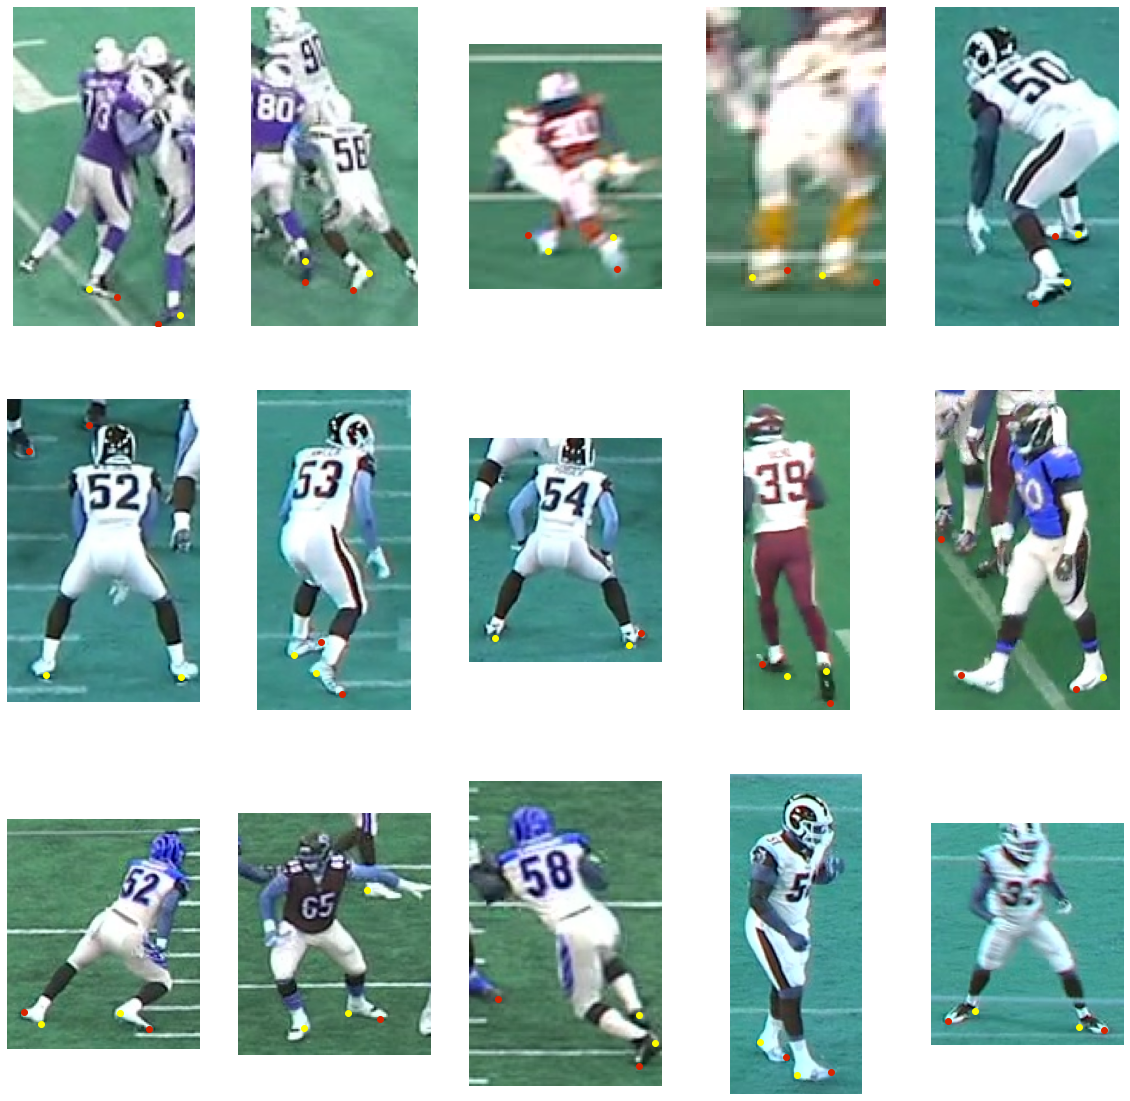

In [ ]:
%matplotlib inline

plt.figure(figsize = (20, 20))
for num, x in enumerate(people_list):
    image = x['image_data']
    img = Image.fromarray(image, 'RGB')
    plt.subplot(3, 5, num + 1)
    plt.axis('off')
    plt.imshow(img)
    for k in x['joints']:
       plt.scatter(float(k[0]), float(k[1]), c = ['#d82400' if k[3] == 'toes' else '#fcfc00'])

In [ ]:
# define visualize_keypoints function
def visualize_keypoints(images, keypoints):
    for current_keypoint in keypoints:
        img = Image.fromarray(images, 'RGB')
        img.show()

images = []
keypoints = []
image = kps['image_data']
keypoints = kps['joints']

visualize_keypoints(image, keypoints)

In [ ]:
# set some parameter values
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 5
NUM_KEYPOINTS = 4

In [ ]:
import progressbar

target_size = (220, 220)
resized_images = []
resized_poses = []
original_scale = []
original_poses = []
poses = [x['joints'] for x in people_list]

for idx, x in progressbar.progressbar(enumerate(people_list)):
    image = x['image_data']
    height, width = image.shape[0], image.shape[1]
    scale_w, scale_h = target_size[0]/width, target_size[1]/height
    original_scale.append([width, height])
    temp_resize = []
    temp_og = []
    for j in range(len(poses[idx])):
      og_x = poses[idx][j][0]
      og_y = poses[idx][j][1]
      rescaled_x = og_x*scale_w
      rescaled_y = og_y*scale_h
      temp_og.append((og_x, og_y))
      temp_resize.append((rescaled_x, rescaled_y))

    resized_poses.append(temp_resize)
    original_poses.append(temp_og)

    image = cv2.resize(image, target_size, interpolation = cv2.INTER_AREA)
    resized_images.append(image)

resized_images = np.array(resized_images)
resized_poses = np.array(resized_poses)
original_scale = np.array(original_scale)

| |      #                                         | 1611 Elapsed Time: 0:00:00


In [ ]:
resized_images[0].shape

(220, 220, 3)

In [ ]:
resized_poses.shape

(1612, 4, 2)

In [ ]:
classes = np.array([[p[3] for p in q] for q in poses])
classes

array([['toes', 'heels', 'toes', 'heels'],
       ['toes', 'toes', 'heels', 'heels'],
       ['toes', 'toes', 'heels', 'heels'],
       ...,
       ['toes', 'toes', 'heels', 'heels'],
       ['heels', 'toes', 'heels', 'toes'],
       ['heels', 'heels', 'heels', 'heels']], dtype='<U5')

In [ ]:
a = [len(i) == 4 for i in resized_poses]
sum(a)

1612

<Figure size 432x288 with 0 Axes>

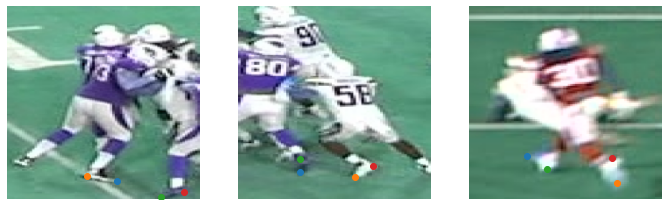

In [ ]:
%matplotlib inline

plt.clf()
plt.figure(figsize = (20, 20))
for num, x in enumerate(resized_images[0:3]):
    img = Image.fromarray(x, 'RGB')
    plt.subplot(3, 5, num + 1)
    plt.axis('off')
    plt.imshow(img)
    for w in range(len(resized_poses[num])):
      plt.scatter(float(resized_poses[num][w][0]), float(resized_poses[num][w][1]))

In [ ]:
# split data into training (70%) and testing (30%) sets
train_images, val_images, train_poses, val_poses, train_classes, val_classes = train_test_split(resized_images, resized_poses, classes, test_size = 0.30)

## Model 1: DeepPose Model

In [ ]:
import scipy.io
import scipy

class DeepPoseModel():
  def __init__(self, train_images, train_poses, val_images, val_poses, training_config):
    self.train_images = train_images
    self.train_poses = np.array(train_poses)/220
    self.val_images = list(val_images)
    self.val_poses = [v.reshape(8, 1)/220 for v in val_poses]
    self.training_config = training_config

    self.model = self.define_model()
    print(self.model.summary())
    self.cascade_1 = self.define_model(final_op = 2)
    self.model.compile(optimizer = tf.keras.optimizers.Adam(training_config['Learning Rate']), loss = tf.keras.losses.mse)

    if training_config['Train model'] == True:
      self.train_model()

  # tried to create a custom loss function by combining binary cross entropy and MSE

  #def loss_binary(self, y_true, y_pred):
    #return tf.keras.losses.BinaryCrossentropy(y_true, y_pred)

  #def loss_mse(self, y_true, y_pred):
    #return tf.keras.losses.mse(y_true, y_pred)

  #def custom_loss(self, y_true, y_pred):
    #return self.loss_binary(y_true[:, 2], y_pred[:, 2]) + self.loss_mse(y_true[:, 0:2], y_pred[:, 0:2])

  def save_model(self):
    self.checkpoint.save(file_prefix = self.checkpoint_prefix)

  def load_model(self):
    checkpoint_dir = '/content/drive/My Drive/logs/DeepPosev1'
    self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
    self.checkpoint = tf.train.Checkpoint(model = self.model, cascade = self.cascade_1)
    self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

  def to_relative_coord(self, coord, size):
    # change pose scale to [-1, 1] scale
    return coord/size*2-1

  def to_absolute_coord(self, coord, size):
    # change pose scale to scale on image size
    return (coord + 1)/2*size

  def draw_pose(self, image_name):
    # model draw pose on new image
    img = plt.imread(image_name)

    img_resized = cv2.resize(img, (220, 220), interpolation = cv2.INTER_AREA)
    poses = self.model.predict(np.array([img_resized]))[0]
    poses_x, poses_y = poses[:14], poses[14:]
    poses_x = self.to_absolute_coord(poses_x, img.shape[1])
    poses_y = self.to_absolute_coord(poses_y, img.shape[0])

    plt.imshow(img)
    plt.scatter(poses_x, poses_y, c = 'r')
    plt.show()

  def train_model(self):
    val_dataset = tf.data.Dataset.from_tensor_slices((self.val_images, self.val_poses))
    val_dataset = val_dataset.batch(64)
    self.train_poses = self.train_poses.reshape(len(self.train_poses), -1)
    print(self.train_poses)
    loss = []
    val_loss = []
    for epoch in range(self.training_config['Epochs']):
      print('Epoch', epoch + 1)
      training_history = self.model.fit(x = self.train_images, y = self.train_poses, epochs = 1, batch_size = 128, validation_data = val_dataset)
      loss.append(training_history.history['loss'])
      val_loss.append(training_history.history['val_loss'])
    self.training_log = {'loss': loss, 'val_loss': val_loss}

  def define_model(self, final_op = 8):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(48, 11, (4, 4), padding = 'same', input_shape = (220, 220, 3)))
    model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(128, 5, (2, 2), padding = 'same'))
    model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(192, 3, (2, 2), padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(192, 3, (1, 1), padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(192, 3, (1, 1), padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(4096, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(4096, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(8, activation = 'linear'))
    return model

In [ ]:
with tf.device('/device:GPU:0'):
  DeepPose = DeepPoseModel(train_images, train_poses, val_images, val_poses, {'Train model': True, 'Learning Rate': 0.0005, 'Epochs': 20}) # learning rate used in original DeepPose paper # tested 20, 50, 100 epochs

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 48)        17472     
                                                                 
 lambda (Lambda)             (None, 55, 55, 48)        0         
                                                                 
 re_lu (ReLU)                (None, 55, 55, 48)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 48)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       153728    
                                                                 
 lambda_1 (Lambda)           (None, 14, 14, 128)       0         
                                                      

In [ ]:
predictionsDeepPose = DeepPose.model.predict(val_images)
predictionsDeepPose = [p.reshape(4, 2)*220 for p in predictionsDeepPose]

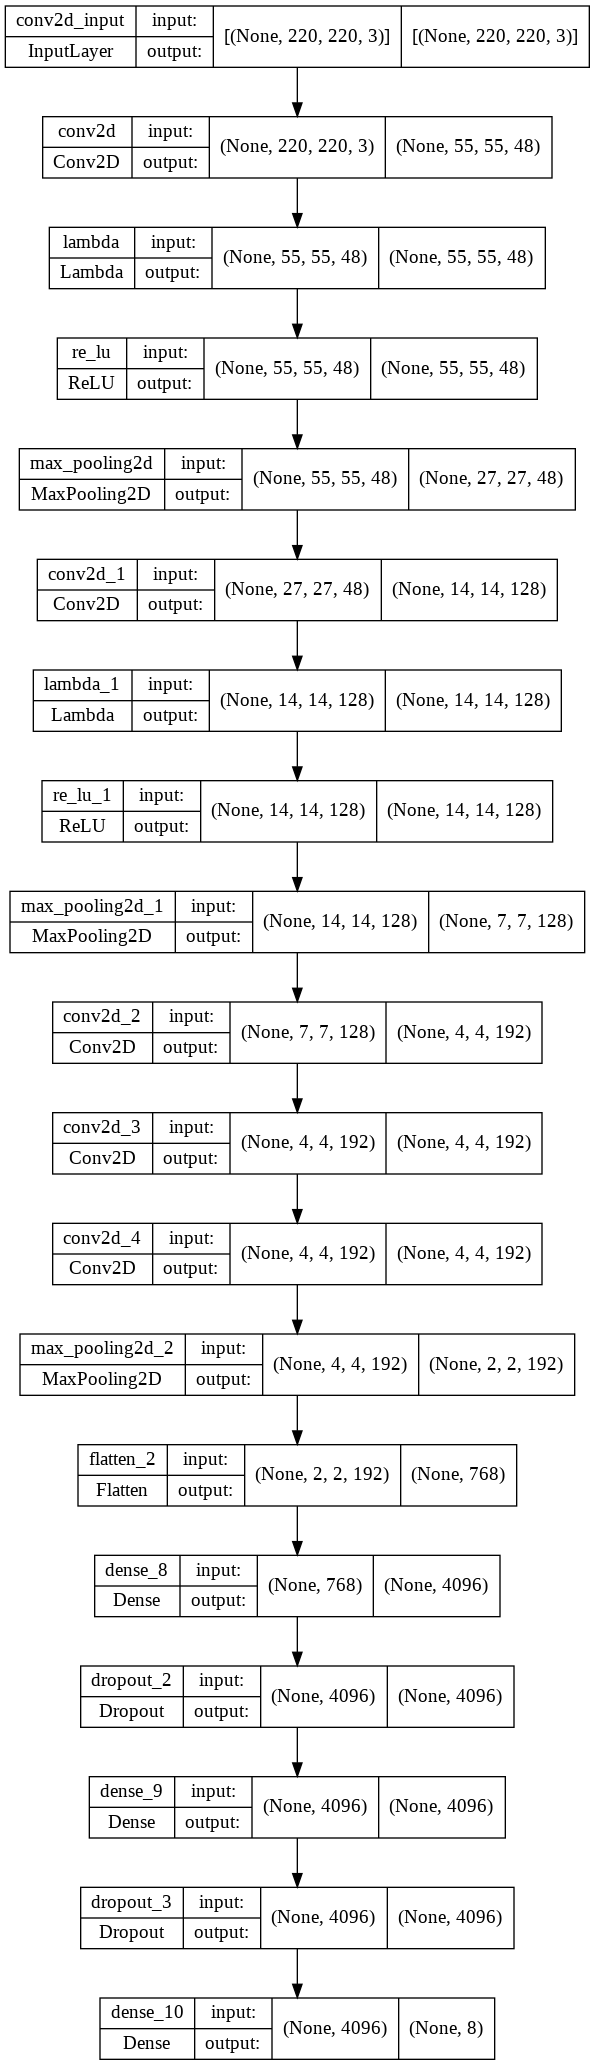

In [ ]:
tf.keras.utils.plot_model(DeepPose.model, show_shapes = True)

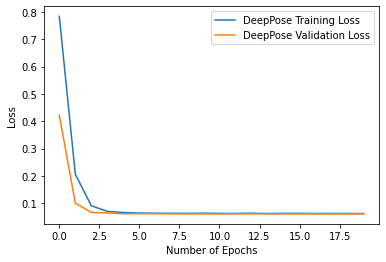

In [ ]:
plt.plot(DeepPose.training_log['loss'], label = 'DeepPose Training Loss')
plt.plot(DeepPose.training_log['val_loss'], label = 'DeepPose Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

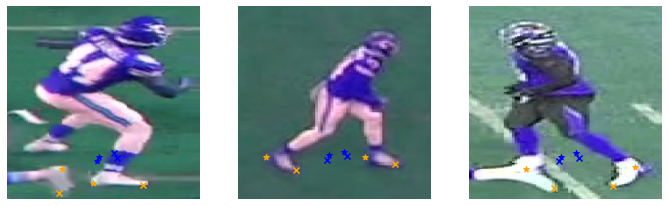

In [ ]:
%matplotlib inline

plt.clf()
plt.figure(figsize = (20, 20))
for num, x in enumerate(val_images[0:3]):
    img = Image.fromarray(x, 'RGB')
    plt.subplot(3, 5, num + 1)
    plt.axis('off')
    plt.imshow(img)
    for w in range(len(val_poses[num])):
      plt.scatter(float(val_poses[num][w][0]), float(val_poses[num][w][1]), c = 'orange', marker = ['x' if vc == 'toes' else '*' for vc in val_classes[num]][w])
      plt.scatter(predictionsDeepPose[num][w][0], predictionsDeepPose[num][w][1], c = 'blue', marker = ['x' if vc == 'toes' else '*' for vc in val_classes[num]][w])

## Model 2: Modified AlexNet Model

In [ ]:
class ModifiedAlexNetModel():
  def __init__(self, train_images, train_poses, val_images, val_poses, training_config):
    self.train_images = train_images
    self.train_poses = np.array(train_poses)/220
    self.val_images = list(val_images)
    self.val_poses = [v.reshape(8, 1)/220 for v in val_poses]
    self.training_config = training_config

    self.model = self.define_model()
    print(self.model.summary())
    self.cascade_1 = self.define_model(final_op = 2)
    self.model.compile(optimizer = tf.keras.optimizers.Adam(training_config['Learning Rate']), loss = tf.keras.losses.mse)

    if training_config['Train model'] == True:
      self.train_model()

  # tried to create a custom loss function by combining binary cross entropy and MSE

  #def loss_binary(self, y_true, y_pred):
    #return tf.keras.losses.BinaryCrossentropy(y_true, y_pred)

  #def loss_mse(self, y_true, y_pred):
    #return tf.keras.losses.mse(y_true, y_pred)

  #def custom_loss(self, y_true, y_pred):
    #return self.loss_binary(y_true[:, 2], y_pred[:, 2]) + self.loss_mse(y_true[:, 0:2], y_pred[:, 0:2])

  def save_model(self):
    self.checkpoint.save(file_prefix = self.checkpoint_prefix)

  def load_model(self):
    checkpoint_dir = '/content/drive/My Drive/logs/DeepPosev1'
    self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
    self.checkpoint = tf.train.Checkpoint(model = self.model, cascade = self.cascade_1)
    self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

  def to_relative_coord(self, coord, size):
    # change pose scale to [-1, 1] scale
    return coord/size*2-1

  def to_absolute_coord(self, coord, size):
    # change pose scale to scale on image size
    return (coord + 1)/2*size

  def draw_pose(self, image_name):
    # model draw pose on new image
    img = plt.imread(image_name)

    img_resized = cv2.resize(img, (220, 220), interpolation = cv2.INTER_AREA)
    poses = self.model.predict(np.array([img_resized]))[0]
    poses_x, poses_y = poses[:14], poses[14:]
    poses_x = self.to_absolute_coord(poses_x, img.shape[1])
    poses_y = self.to_absolute_coord(poses_y, img.shape[0])

    plt.imshow(img)
    plt.scatter(poses_x, poses_y, c = 'r')
    plt.show()

  def train_model(self):
    val_dataset = tf.data.Dataset.from_tensor_slices((self.val_images, self.val_poses))
    val_dataset = val_dataset.batch(64)
    self.train_poses = self.train_poses.reshape(len(self.train_poses), -1)
    print(self.train_poses)
    loss = []
    val_loss = []
    for epoch in range(self.training_config['Epochs']):
      print('Epoch', epoch + 1)
      training_history = self.model.fit(x = self.train_images, y = self.train_poses, epochs = 1, batch_size = 128, validation_data = val_dataset)
      loss.append(training_history.history['loss'])
      val_loss.append(training_history.history['val_loss'])
    self.training_log = {'loss': loss, 'val_loss': val_loss}

  def define_model(self, final_op = 8):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(48, 11, (4, 4), padding = 'same', input_shape = (220, 220, 3)))
    model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(128, 5, (2, 2), padding = 'same'))
    model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(128, 5, (2, 2), padding = 'same'))
    model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Conv2D(192, 3, (2, 2), padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(192, 3, (1, 1), padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(192, 3, (1, 1), padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(192, 3, (2, 2), padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(192, 3, (1, 1), padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(192, 3, (1, 1), padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(4096, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(4096, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(8, activation = 'sigmoid'))
    return model

In [ ]:
with tf.device('/device:GPU:0'):
  ModifiedAlexNet = ModifiedAlexNetModel(train_images, train_poses, val_images, val_poses, {'Train model': True, 'Learning Rate': 0.001, 'Epochs': 20}) # optinal learning rate # tested 20, 50, 100 epochs

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 55, 55, 48)        17472     
                                                                 
 lambda_4 (Lambda)           (None, 55, 55, 48)        0         
                                                                 
 re_lu_4 (ReLU)              (None, 55, 55, 48)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 48)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 128)       153728    
                                                                 
 lambda_5 (Lambda)           (None, 14, 14, 128)       0         
                                                      

In [ ]:
predictionsModifiedAlexNet = ModifiedAlexNet.model.predict(val_images)
predictionsModifiedAlexNet = [p.reshape(4, 2)*220 for p in predictionsModifiedAlexNet]

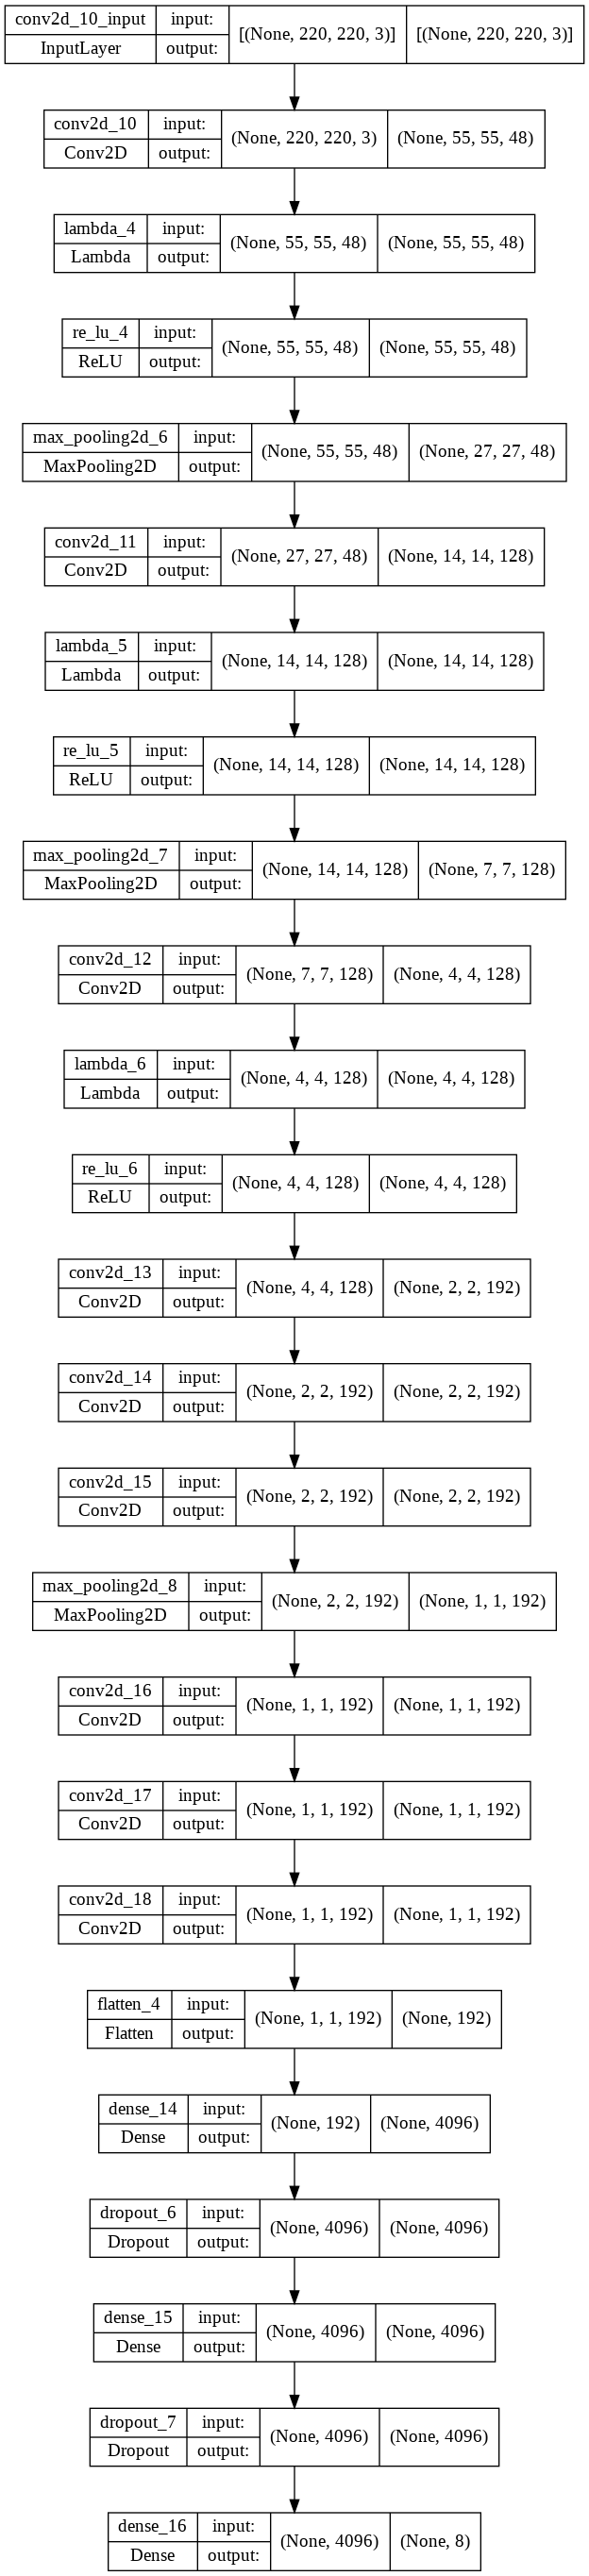

In [ ]:
tf.keras.utils.plot_model(ModifiedAlexNet.model, show_shapes = True)

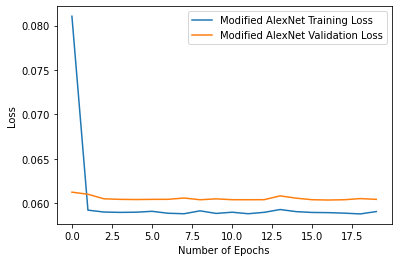

In [ ]:
plt.plot(ModifiedAlexNet.training_log['loss'], label = 'Modified AlexNet Training Loss')
plt.plot(ModifiedAlexNet.training_log['val_loss'], label = 'Modified AlexNet Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

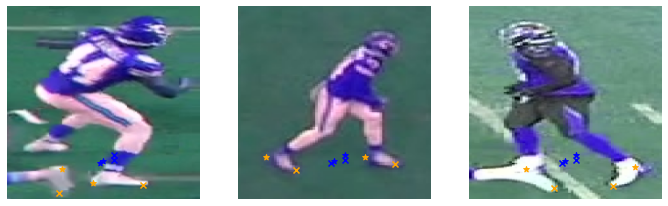

In [ ]:
%matplotlib inline

plt.clf()
plt.figure(figsize = (20, 20))
for num, x in enumerate(val_images[0:3]):
    img = Image.fromarray(x, 'RGB')
    plt.subplot(3, 5, num + 1)
    plt.axis('off')
    plt.imshow(img)
    for w in range(len(val_poses[num])):
      plt.scatter(float(val_poses[num][w][0]), float(val_poses[num][w][1]), c = 'orange', marker = ['x' if vc == 'toes' else '*' for vc in val_classes[num]][w])
      plt.scatter(predictionsModifiedAlexNet[num][w][0], predictionsModifiedAlexNet[num][w][1], c = 'blue', marker = ['x' if vc == 'toes' else '*' for vc in val_classes[num]][w])

## Model 3: Modified ResNet50 Model

In [ ]:
# ResNet50 data preprocessing - rescale images (224, 224)
target_size_res = (224, 224)
resized_images_res = []
resized_poses_res = []
original_scale_res = []
original_poses_res = []
poses=[x['joints'] for x in people_list]

for idx, x in progressbar.progressbar(enumerate(people_list)):
    image = x['image_data']
    height, width = image.shape[0], image.shape[1]
    scale_w_res, scale_h_res = target_size_res[0]/width, target_size_res[1]/height
    original_scale_res.append([width, height])
    temp_resize_res = []
    temp_og_res = []
    for j in range(len(poses[idx])):
      og_x_res = poses[idx][j][0]
      og_y_res = poses[idx][j][1]
      rescaled_x_res = og_x_res*scale_w_res
      rescaled_y_res = og_y_res*scale_h_res
      temp_og_res.append((og_x_res, og_y_res))
      temp_resize_res.append((rescaled_x_res, rescaled_y_res))

    resized_poses_res.append(temp_resize_res)
    original_poses_res.append(temp_og_res)

    image = cv2.resize(image, target_size_res, interpolation = cv2.INTER_AREA)
    resized_images_res.append(image)

resized_images_res = np.array(resized_images_res)
resized_poses_res = np.array(resized_poses_res)
original_scale_res = np.array(original_scale_res)

| |    #                                           | 1611 Elapsed Time: 0:00:00


In [ ]:
# redo train/test split
train_images_res, val_images_res, train_poses_res, val_poses_res, train_classes_res, val_classes_res = train_test_split(resized_images_res, resized_poses_res, classes, test_size = 0.30)

In [ ]:
# model definition
class ResNet50Model():
  def __init__(self, train_images_res, train_poses_res, val_images_res, val_poses_res, training_config):
    self.train_images_res = train_images_res
    self.train_poses_res = np.array(train_poses_res)/224
    self.val_images_res = list(val_images_res)
    self.val_poses_res = [v.reshape(8, 1)/224 for v in val_poses_res]
    self.training_config = training_config

    self.model = self.define_model()
    print(self.model.summary())
    self.cascade_1 = self.define_model(final_op = 2)
    self.model.compile(optimizer = tf.keras.optimizers.Adam(training_config['Learning Rate']), loss = tf.keras.losses.mse)

    if training_config['Train model'] == True:
      self.train_model_res()

  # tried to create a custom loss function by combining binary cross entropy and MSE

  #def loss_binary(self, y_true, y_pred):
    #return tf.keras.losses.BinaryCrossentropy(y_true, y_pred)

  #def loss_mse(self, y_true, y_pred):
    #return tf.keras.losses.mse(y_true, y_pred)

  #def custom_loss(self, y_true, y_pred):
    #return self.loss_binary(y_true[:, 2], y_pred[:, 2]) + self.loss_mse(y_true[:, 0:2], y_pred[:, 0:2])

  def save_model_res(self):
    self.checkpoint.save(file_prefix = self.checkpoint_prefix)

  def load_model_res(self):
    checkpoint_dir = '/content/drive/My Drive/logs/resNetv1'
    self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
    self.checkpoint = tf.train.Checkpoint(model = self.model, cascade = self.cascade_1)
    self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

  def to_relative_coord_res(self, coord, size):
    # change pose scale to [-1, 1] scale
    return coord/size*2-1

  def to_absolute_coord_res(self, coord, size):
    # change pose scale to scale on image size
    return (coord + 1)/2*size

  def draw_pose_res(self, image_name):
    # model draw pose on new image
    img=plt.imread(image_name)

    img_resized = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
    poses = self.model.predict(np.array([img_resized]))[0]
    poses_x, poses_y = poses[:14], poses[14:]
    poses_x = self.to_absolute_coord(poses_x, img.shape[1])
    poses_y = self.to_absolute_coord(poses_y, img.shape[0])

    plt.imshow(img)
    plt.scatter(poses_x, poses_y, c = 'r')
    plt.show()

  def train_model_res(self):
    val_dataset_res = tf.data.Dataset.from_tensor_slices((self.val_images_res, self.val_poses_res))
    val_dataset_res = val_dataset_res.batch(64)
    self.train_poses_res = self.train_poses_res.reshape(len(self.train_poses_res), -1)
    print(self.train_poses_res)
    loss = []
    val_loss = []
    for epoch in range(self.training_config['Epochs']):
      print('Epoch', epoch + 1)
      training_history = self.model.fit(x = self.train_images_res, y = self.train_poses_res, epochs = 1, batch_size = 128, validation_data = val_dataset_res)
      loss.append(training_history.history['loss'])
      val_loss.append(training_history.history['val_loss'])
    self.training_log = {'loss': loss, 'val_loss': val_loss}

  def define_model(self,final_op = 8):
    resnet_model = models.Sequential()
    pretrained_model = tf.keras.applications.ResNet50(include_top = False,
                                                      input_shape = (224, 224, 3),
                                                      pooling = "avg",
                                                      weights = "imagenet"
                                                      )
    for layer in pretrained_model.layers[:10]:
      layer.trainable = False

    resnet_model.add(pretrained_model)
    resnet_model.add(layers.Flatten())
    resnet_model.add(layers.Dense(32, activation = "relu"))
    resnet_model.add(layers.Dropout(0.5))
    resnet_model.add(layers.Dense(32, activation = "relu"))
    resnet_model.add(layers.Dense(32, activation = "relu"))
    resnet_model.add(layers.Dense(8, activation = "sigmoid"))
    return resnet_model

In [ ]:
with tf.device('/device:GPU:0'):
  ResNet50 = ResNet50Model(train_images_res, train_poses_res, val_images_res, val_poses_res, {'Train model': True, 'Learning Rate': 0.001, 'Epochs': 20}) # session crashes if number of epochs set to more than 20

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 8)                 2

In [ ]:
predictionsResNet50 = ResNet50.model.predict(val_images_res)
predictionsResNet50 = [p.reshape(4, 2)*224 for p in predictionsResNet50]

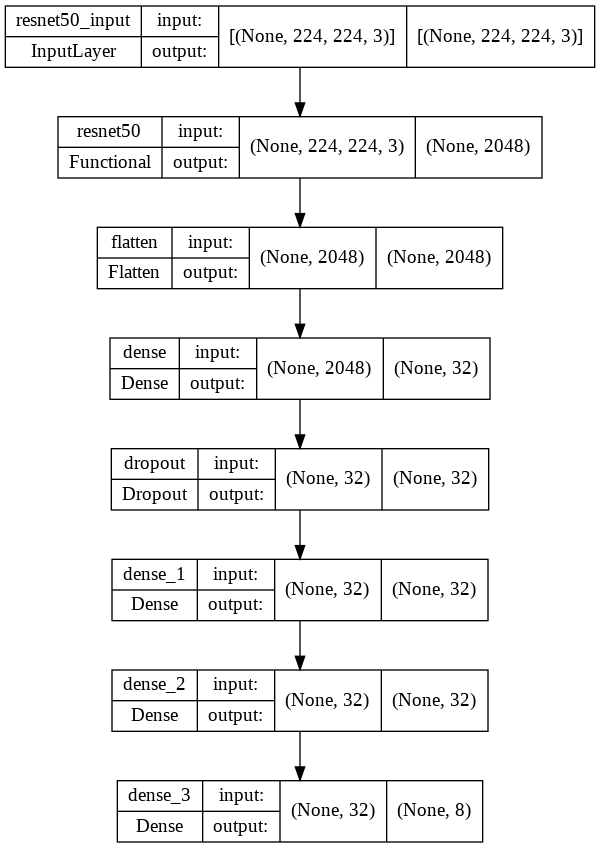

In [ ]:
tf.keras.utils.plot_model(ResNet50.model, show_shapes = True)

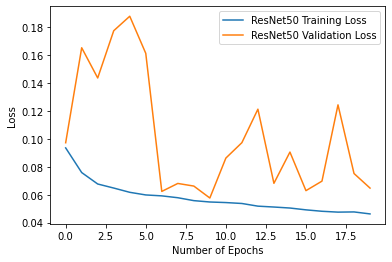

In [ ]:
plt.plot(ResNet50.training_log['loss'], label = 'ResNet50 Training Loss')
plt.plot(ResNet50.training_log['val_loss'], label = 'ResNet50 Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

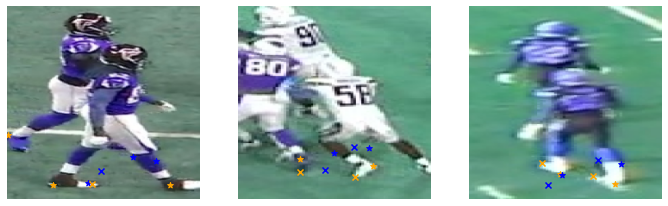

In [ ]:
%matplotlib inline

plt.clf()
plt.figure(figsize = (20, 20))
for num, x in enumerate(val_images_res[0:3]):
    img = Image.fromarray(x, 'RGB')
    plt.subplot(3, 5, num + 1)
    plt.axis('off')
    plt.imshow(img)
    for w in range(len(val_poses_res[num])):
      plt.scatter(float(val_poses_res[num][w][0]), float(val_poses_res[num][w][1]), c = 'orange', marker = ['x' if vc == 'toes' else '*' for vc in val_classes_res[num]][w])
      plt.scatter(predictionsResNet50[num][w][0], predictionsResNet50[num][w][1], c = 'blue', marker = ['x' if vc == 'toes' else '*' for vc in val_classes_res[num]][w])